**Importing libraries**

In [1]:
# Keras e TF

#import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Base
import os 
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

from keras.utils import load_img

import pydot
import pydotplus
from pydotplus import graphviz

from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from custom_resnet import ResNet18


from keras.models import Model
from keras.optimizers import Adam

In [2]:
keras.__version__

'2.10.0'

**Setting path to the dataset**

In [3]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) +
              '\\adni-images-Full-resized160x192-binary'))

In [4]:
print(os.getcwd())

d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192-binary


# Loading Dataset

In [4]:
data_dir = Path(os.getcwd())

def data_mean_std():
    names = []
    for root, dirs, files in os.walk(data_dir):
        if "train" in root:
            for file in files:
                names.append(root + '/' + file)
    
    print(len(names))
                
    array = []
    for name in names:
        try:
            img = load_img(name, color_mode = 'grayscale', target_size = (160, 192))
            img_array = np.asarray(img)
            array.append(img_array)
        except:
            print("Name: ", name)
            continue
    
    print(img_array.shape) # Correct amount of images

    array = np.asarray(array)
    print(array.shape)
    print(array.mean().shape, array.std().shape)
    return array.mean(), array.std()
""" 
stats_file = open(stats_path, 'r')
stats_lst = stats_file.read().split('\n')
mean = float(stats_lst[0])
std = float(stats_lst[1])"""
mean, std = data_mean_std()

print(mean, std)


61829
Name:  d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192-binary\no_balance_binary\logs_no_balance_binary\train/events.out.tfevents.1686073730.GIORGIO-LAPTOP.43900.0.v2
Name:  d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192-binary\train\ad/ADNI_021_S_0753_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20071115091031185_S18712_I82162_101.png


Use the pre-computed values (oversampling GAN):

In [5]:
mean = 35.80925715423529
std = 45.16736479384096

In [6]:
def normalize(x):
    return (x - mean) / std

In [7]:
batch_size = 32 # Batch size

train_path = './train_rand_sub_under'
test_path = './test'
valid_path = './valid'
#rescale = 1./255.
train_datagen = ImageDataGenerator(preprocessing_function = normalize)
test_datagen = ImageDataGenerator(preprocessing_function = normalize)
valid_datagen = ImageDataGenerator(preprocessing_function = normalize)

In [8]:
train_data = train_datagen.flow_from_directory(
        train_path,
        color_mode = 'grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode= "categorical")

Found 53930 images belonging to 2 classes.


In [9]:
validation_data = valid_datagen.flow_from_directory(
        valid_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode= "categorical")

Found 10748 images belonging to 2 classes.


In [10]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode= "categorical")

Found 4572 images belonging to 2 classes.


In [10]:
train_data.class_indices

{'ad': 0, 'nor': 1}

In [12]:
validation_data.class_indices

{'ad': 0, 'nor': 1}

In [14]:
test_data.class_indices

{'ad': 0, 'nor': 1}

In [11]:
train_ad = len(os.listdir(os.getcwd() + '\\train_rand_sub_under\\ad'))
train_nor = len(os.listdir(os.getcwd() + '\\train_rand_sub_under\\nor'))
train_tot = train_ad + train_nor
print(train_ad/train_tot, train_nor/train_tot)

0.4105136287780456 0.5894863712219544


In [12]:
test_ad = len(os.listdir(os.getcwd() + '\\test\\ad'))
test_nor = len(os.listdir(os.getcwd() + '\\test\\nor'))
test_tot = test_ad + test_nor
print(test_ad/test_tot, test_nor/test_tot)

0.5201224846894138 0.4798775153105862


In [13]:
valid_ad = len(os.listdir(os.getcwd() + '\\valid\\ad'))
valid_nor = len(os.listdir(os.getcwd() + '\\valid\\nor'))
valid_tot = valid_ad + valid_nor
print(valid_ad/valid_tot, valid_nor/valid_tot)

0.3731857089691105 0.6268142910308895


# Model Definition

Changing the folder to data path to save weights into

In [14]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [15]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [16]:
METRICS = [ 
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

In [17]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [18]:
tb = TensorBoard(log_dir =os.getcwd() + '\\no_balance_binary\\logs_no_balance_binary', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath=os.getcwd() + '\\no_balance_binary\\best_model_no_balance_binary',
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=2)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

# x = Dropout(0.25)(x)

x = Dense(2, activation = 'softmax')(x)


ft_resnet = Model(resnet.input, x)
optimizer = Adam(learning_rate = 0.001)
ft_resnet.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = METRICS)

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (

Changing back the folder to data path

In [19]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192-binary'))
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192-binary'

In [20]:
version = "v1"
epochs = 20

print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

#fit_generator

history_dcnn = ft_resnet.fit(train_data, 
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             workers = 4,
                             callbacks = [tb, model_chkp, lr_reducer, early_stopper],
                             validation_data = validation_data, 
                             validation_steps = valid_steps)


53930 10748
1686.0 336.0
Epoch 1/20
1686/1686 [==============================] - 104s 58ms/step - loss: 0.5246 - tp: 39653.0000 - fp: 14277.0000 - tn: 39653.0000 - fn: 14277.0000 - accuracy: 0.7353 - precision: 0.7353 - recall: 0.7353 - auc: 0.8184 - val_loss: 1.1215 - val_tp: 5727.0000 - val_fp: 5021.0000 - val_tn: 5727.0000 - val_fn: 5021.0000 - val_accuracy: 0.5328 - val_precision: 0.5328 - val_recall: 0.5328 - val_auc: 0.5803 - lr: 0.0010
Epoch 2/20
1686/1686 [==============================] - 97s 57ms/step - loss: 0.2767 - tp: 47455.0000 - fp: 6475.0000 - tn: 47455.0000 - fn: 6475.0000 - accuracy: 0.8799 - precision: 0.8799 - recall: 0.8799 - auc: 0.9532 - val_loss: 2.2793 - val_tp: 5046.0000 - val_fp: 5702.0000 - val_tn: 5046.0000 - val_fn: 5702.0000 - val_accuracy: 0.4695 - val_precision: 0.4695 - val_recall: 0.4695 - val_auc: 0.4988 - lr: 0.0010
Epoch 3/20
1686/1686 [==============================] - 98s 58ms/step - loss: 0.1549 - tp: 50630.0000 - fp: 3300.0000 - tn: 50630.0000

In [21]:
arch_name = 'bs_{}'.format(batch_size)

continue_model_path = '..\\models\\best_model_no_balance_binary\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs)
ft_resnet.save(continue_model_path)
np.save(f'..\\models\\best_model_no_balance_binary\\{version}_{arch_name}_{epochs}_eps.npy',
        history_dcnn.history)

In [22]:
import pickle 
ft_resnet.save_weights('..\\models\\best_model_no_balance_binary\\' + '{}_{}_{}_eps_wheights_only.h5'.format(version, arch_name, epochs))
symbolic_weights = getattr(ft_resnet.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open('..\\models\\best_model_no_balance_binary\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'wb') as f:
    pickle.dump(weight_values, f)

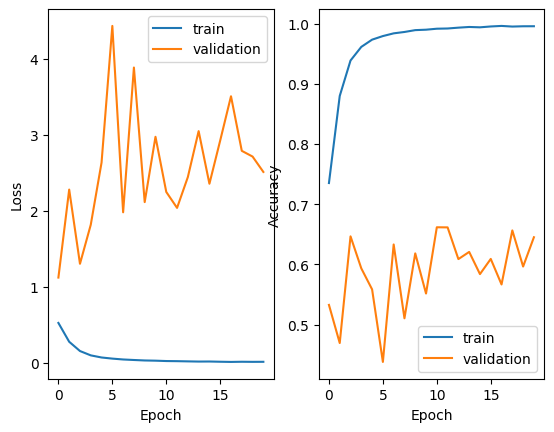

In [23]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn.history['loss'])
plt.plot(history_dcnn.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn.history['accuracy'])
plt.plot(history_dcnn.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Continue training

In [24]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [25]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [26]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5)
]

In [27]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [31]:
tb = TensorBoard(log_dir =os.getcwd() + '\\gan_over\\logs_gan_over', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath=os.getcwd() + '\\gan_over\\best_model_gan_over',
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=3)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

x = Dropout(0.25)(x)

x = Dense(3, activation = 'softmax')(x)


ft_resnet = Model(resnet.input, x)
ft_resnet.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = METRICS)

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization) 

Changing back the folder to data path

In [32]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192'))
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192'

In [33]:
print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

218575 18024
6831.0 564.0


In [39]:
import pickle 
import tensorflow

ft_resnet = tensorflow.keras.models.load_model('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs))
old_weights = ft_resnet.optimizier.get_weights()

ft_resnet._make_train_function()
with open('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'rb') as f:
    weight_values = pickle.load(f)
ft_resnet.optimizer.set_weights(weight_values)

AttributeError: 'Functional' object has no attribute 'optimizier'

In [38]:
import pickle 

ft_resnet.load_weights('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs))
ft_resnet.make_train_function()
with open('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'rb') as f:
    weight_values = pickle.load(f)
ft_resnet.optimizer.set_weights(weight_values)

#fit_generator


AttributeError: 'Functional' object has no attribute 'load_model'

In [ ]:
version = "v2"
epochs = 30

In [ ]:
history_dcnn = ft_resnet.fit(train_data, 
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             workers = 4,
                             callbacks = [tb, model_chkp, lr_reducer, early_stopper],
                             validation_data = validation_data, 
                             validation_steps = valid_steps)


In [ ]:
arch_name = 'bs_{}'.format(batch_size)

continue_model_path = '..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs)
ft_resnet.save(continue_model_path)
np.save(f'..\\models\\best_model_gan_over\\{version}_{arch_name}_{epochs}_eps.npy',
        history_dcnn.history)

In [ ]:
import pickle 
ft_resnet.save_weights('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_wheights_only.h5'.format(version, arch_name, epochs))
symbolic_weights = getattr(ft_resnet.optimizer, 'weights')
weight_values = K.batch_get_value(symbolic_weights)
with open('..\\models\\best_model_gan_over\\' + '{}_{}_{}_eps_optimizer.pkl'.format(version, arch_name, epochs), 'wb') as f:
    pickle.dump(weight_values, f)

# Load Model

In [8]:
#os.chdir('C:/Users/marco/Desktop/Local_Documents/models/NoBalance')

In [24]:
# Load model
net_dcnn = keras.models.load_model("..\\models\\best_model_no_balance_binary\\v1_bs_32_20_eps.h5")

In [25]:
net_dcnn.metrics_names

['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc']

In [26]:
# Load hystory and convert to dict
history = np.load('..\\models\\best_model_no_balance_binary\\v1_bs_32_20_eps.npy', allow_pickle=True).item()

# Model Evaluation

In [27]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [28]:
CATEGORIES = "ad", "nor"

In [29]:
history.keys()

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'lr'])

In [30]:
test_data = validation_data

In [31]:
history['accuracy'][:1+1]

[0.7352679371833801, 0.879936933517456]

In [32]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][:index+5]
    plt.plot(train_values)
    test_values = history['val_' + item][:index+5]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [33]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusione Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [34]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [37]:
def model_summary(model, history, name):
    val_acc = history['val_accuracy'] #validation accuracy history
    index= val_acc.index(max(val_acc))
    print('Best Epochs:', index)


    test_loss, _, _, _, _,test_accuracy, test_precision, test_recall, auc = model.evaluate(test_data, verbose=1)

    train_accuracy = history['accuracy'][index]
    train_loss = history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)

    print('---'*15) 
    print(name)
    print('> Accuracy on train:',round(train_accuracy, 2), 
            '\tLoss on train:', round(train_loss,2))
    

    print('> Accuracy on test:',round(test_accuracy, 2),
            '\tLoss on test:',round(test_loss,2))

    print('---'*15)
    print('> predicting test')
    print('---'*15)

    printResults(name, model)

Best Epochs: 10
336/336 [==============================] - 9s 26ms/step - loss: 2.5113 - tp: 6935.0000 - fp: 3813.0000 - tn: 6935.0000 - fn: 3813.0000 - accuracy: 0.6452 - precision: 0.6452 - recall: 0.6452 - auc: 0.6840


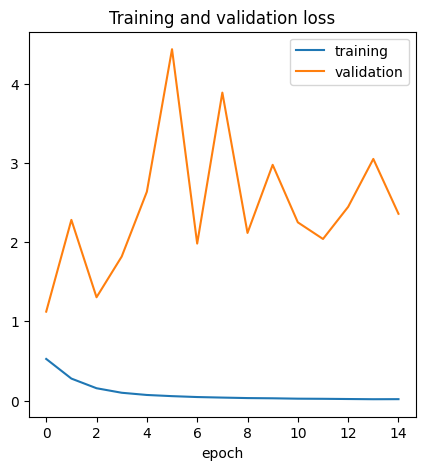

<Figure size 500x500 with 0 Axes>

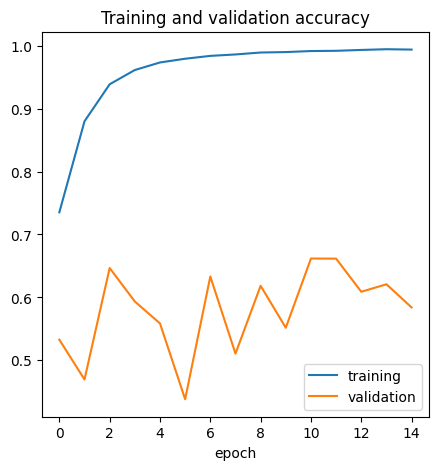

---------------------------------------------
DCCN - Random Undersampling
> Accuracy on train: 0.99 	Loss on train: 0.02
> Accuracy on test: 0.65 	Loss on test: 2.51
---------------------------------------------
> predicting test
---------------------------------------------
336/336 [==============================] - 8s 24ms/step


<Figure size 500x500 with 0 Axes>

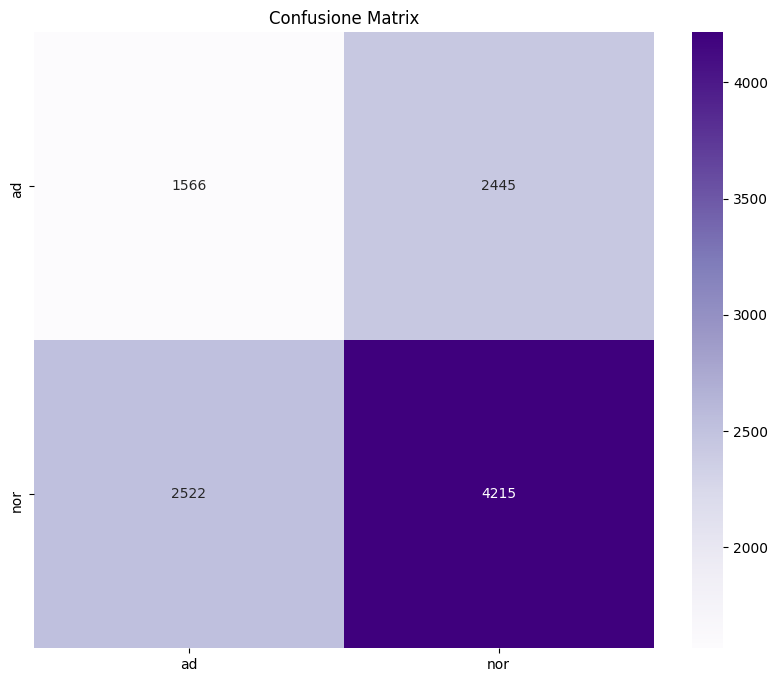

.............................................
> Correct Predictions: 5781
> Wrong Predictions: 4967
.............................................
              precision    recall  f1-score   support

          ad       0.38      0.39      0.39      4011
         nor       0.63      0.63      0.63      6737

    accuracy                           0.54     10748
   macro avg       0.51      0.51      0.51     10748
weighted avg       0.54      0.54      0.54     10748



In [38]:
model_summary(net_dcnn, history, 'DCCN - Random Undersampling')